# DCGAN 실습

- 논문 제목 : Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks **(ICLR 2016)**
- 학습 데이터셋: **MNIST** (1x28x28)

## 필요한 라이브러리 불러오기

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.utils as utils
from torchvision import datasets
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torch.autograd import Variable

In [3]:
print('numpy: ' + np.__version__)
print('pandas: ' + pd.__version__)
print('matlotlib: ' + matplotlib.__version__)
print('torch: ' + torch.__version__)
print('torchvision: ' + torchvision.__version__)

numpy: 1.19.5
pandas: 1.1.5
matlotlib: 3.3.4
torch: 1.9.0+cu111
torchvision: 0.10.0+cu111


In [4]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


### 학습 데이터셋 불러오기
- 학습을 위해 MNIST 데이터셋을 불러옵니다.

In [5]:
image_size = 64
batch_size = 128

In [6]:
transforms_train = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
train_dataset = datasets.MNIST(root="./dataset",train = True, download = True, transform = transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers=4)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
def plot(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28,28)

    plt.imshow(img, cmap='gray')
    plt.show()

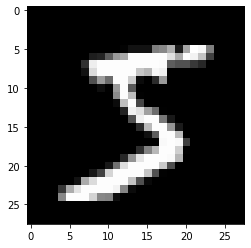

In [8]:
plot(train_dataset.data[0])

In [10]:
# function for visualization
def tc_imshow(img, lbl=""):
    if img.size(0) == 1:
        plt.imshow(img.squeeze(), cmap='gray')
    else:
        plt.imshow(np.transpose(img, (1, 2, 0)))

    plt.title(lbl)
    plt.axis('off')

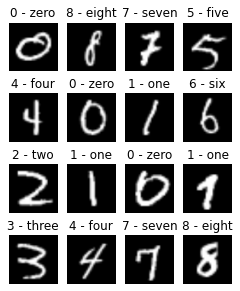

In [13]:
# visualize

# visualize
mini_batch_img, mini_batch_lbl = next(iter(dataloader))

plt.figure(figsize=(4,5))
for i in range(16):
    plt.subplot(4,4,i+1)
    tc_imshow(img=mini_batch_img[i] /2+0.5 ,
              lbl=train_dataset.classes[mini_batch_lbl[i].numpy()])
    plt.axis('off')


In [14]:
dim_noise = 100

In [15]:
# Random sampling from uniform distribution
def random_sample_z_space(batch_size=1, dim_noise=100):
    return torch.rand(batch_size, dim_noise, 1, 1, device=device)

In [16]:
mini_batch_img, mini_batch_lbl = next(iter(dataloader))

In [17]:
mini_batch_img.size()

torch.Size([128, 1, 64, 64])

In [18]:
mini_batch_lbl.size()

torch.Size([128])

## 생성자(Generator) 및 판별자(Discriminator) 모델 정의

In [19]:
dim_G_last2_channel = 64
dim_output = mini_batch_img.size(1)

In [20]:
def initialize_weights(model):
    class_names = model.__class__.__name__

    if class_names.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)

    elif class_names.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [21]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
                    # 100x1 z 1D vector에서 2D vector로의 변환이 없는 이유: 애초에 z random sampling 시 1x1 matrix 형태로 sampling 하면 됨.
                    nn.ConvTranspose2d(in_channels=latent_dim,
                                       out_channels=dim_G_last2_channel*8,
                                       kernel_size=4,
                                       stride=1,
                                       padding=0, 
                                       bias=False),
                    nn.BatchNorm2d(dim_G_last2_channel*8),
                    nn.ReLU(True),

                    nn.ConvTranspose2d(in_channels=dim_G_last2_channel*8,
                                       out_channels=dim_G_last2_channel*4,
                                       kernel_size=4, 
                                       stride=2,
                                       padding=1, 
                                       bias=False),
                    nn.BatchNorm2d(dim_G_last2_channel*4),
                    nn.ReLU(True),

                    nn.ConvTranspose2d(in_channels=dim_G_last2_channel*4,
                                       out_channels=dim_G_last2_channel*2,
                                       kernel_size=4, 
                                       stride=2,
                                       padding=1, 
                                       bias=False),
                    nn.BatchNorm2d(dim_G_last2_channel*2),
                    nn.ReLU(True),

                    nn.ConvTranspose2d(in_channels=dim_G_last2_channel*2,
                                       out_channels=dim_G_last2_channel,
                                       kernel_size=4, 
                                       stride=2,
                                       padding=1, 
                                       bias=False),
                    nn.BatchNorm2d(dim_G_last2_channel),
                    nn.ReLU(True),

                    nn.ConvTranspose2d(in_channels=dim_G_last2_channel,
                                       out_channels=dim_output,
                                       kernel_size=4, 
                                       stride=2,
                                       padding=1, 
                                       bias=False),
                    nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)

        return img

In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=dim_output,
                      out_channels=dim_G_last2_channel,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(dim_G_last2_channel),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=dim_G_last2_channel,
                      out_channels=dim_G_last2_channel*2,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(dim_G_last2_channel*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=dim_G_last2_channel*2,
                      out_channels=dim_G_last2_channel*4,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(dim_G_last2_channel*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=dim_G_last2_channel*4,
                      out_channels=dim_G_last2_channel*8,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(dim_G_last2_channel*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(in_channels=dim_G_last2_channel*8,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),
            nn.Sigmoid()
        )


    def forward(self, img):
        check_validity = self.model(img)

        return check_validity

### 모델 학습 및 샘플링
- 학습을 위해 생성자와 판별자 모델을 초기화합니다.
- 적절한 하이퍼 파라미터를 설정합니다.

In [23]:
# 생성자(generator)와 판별자(discriminator) 초기화
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

generator.apply(initialize_weights)
discriminator.apply(initialize_weights)

# 손실함수 (Loss function)
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr = lr , betas = (0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr = lr , betas = (0.5, 0.999))

In [47]:
import time

n_epochs = 200 # 학습의 횟수(epoch) 설정
sample_interval = 2000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0).view(-1,1,1,1) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0).view(-1,1,1,1) # 가짜(fake): 0

        real_imgs = imgs.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 샘플링
        z = random_sample_z_space(imgs.size(0))

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 1.093300] [G loss: 18.816566] [Elapsed time: 20.55s]
[Epoch 1/200] [D loss: 0.036738] [G loss: 3.059473] [Elapsed time: 41.06s]
[Epoch 2/200] [D loss: 0.023930] [G loss: 3.955622] [Elapsed time: 61.60s]
[Epoch 3/200] [D loss: 0.005655] [G loss: 4.682815] [Elapsed time: 82.12s]
[Epoch 4/200] [D loss: 0.016019] [G loss: 3.883074] [Elapsed time: 102.68s]
[Epoch 5/200] [D loss: 0.013036] [G loss: 4.433365] [Elapsed time: 123.38s]
[Epoch 6/200] [D loss: 0.006604] [G loss: 11.357735] [Elapsed time: 143.85s]
[Epoch 7/200] [D loss: 0.005719] [G loss: 4.705449] [Elapsed time: 164.45s]
[Epoch 8/200] [D loss: 0.211483] [G loss: 1.844736] [Elapsed time: 185.11s]
[Epoch 9/200] [D loss: 0.048083] [G loss: 3.466440] [Elapsed time: 205.77s]
[Epoch 10/200] [D loss: 0.031892] [G loss: 3.546812] [Elapsed time: 226.45s]
[Epoch 11/200] [D loss: 0.008488] [G loss: 4.690178] [Elapsed time: 247.09s]
[Epoch 12/200] [D loss: 0.032217] [G loss: 4.095049] [Elapsed time: 267.70s]
[Epoch 13/2

[Epoch 106/200] [D loss: 0.001209] [G loss: 6.570137] [Elapsed time: 2209.28s]
[Epoch 107/200] [D loss: 0.000989] [G loss: 7.810395] [Elapsed time: 2229.92s]
[Epoch 108/200] [D loss: 0.002634] [G loss: 6.892316] [Elapsed time: 2250.57s]
[Epoch 109/200] [D loss: 0.004524] [G loss: 6.892480] [Elapsed time: 2271.21s]
[Epoch 110/200] [D loss: 0.025141] [G loss: 3.936757] [Elapsed time: 2291.85s]
[Epoch 111/200] [D loss: 3.988121] [G loss: 0.004440] [Elapsed time: 2312.48s]
[Epoch 112/200] [D loss: 0.000739] [G loss: 8.511894] [Elapsed time: 2333.22s]
[Epoch 113/200] [D loss: 0.004376] [G loss: 7.956309] [Elapsed time: 2353.87s]
[Epoch 114/200] [D loss: 0.000799] [G loss: 7.392615] [Elapsed time: 2374.51s]
[Epoch 115/200] [D loss: 0.002025] [G loss: 6.233305] [Elapsed time: 2395.24s]
[Epoch 116/200] [D loss: 0.002124] [G loss: 6.969203] [Elapsed time: 2415.89s]
[Epoch 117/200] [D loss: 0.003081] [G loss: 5.294292] [Elapsed time: 2436.60s]
[Epoch 118/200] [D loss: 0.011030] [G loss: 4.946815

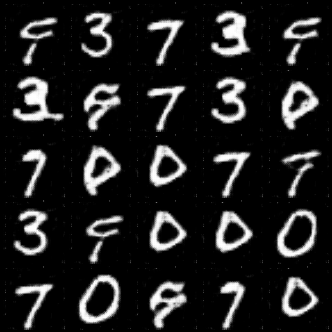

In [48]:
from IPython.display import Image

Image('92000.png')